In [1]:
import numpy as np
import math as math
import matplotlib.pyplot as plt

The resonant frequency of this system is: 0.07957747154594767 Hz.
[1.         1.00000221 1.00000443 ... 1.00555309 1.00555532 1.00555756]
α = 0
γ = -0.5 [rad/s/T]
|M| = 1 [T]


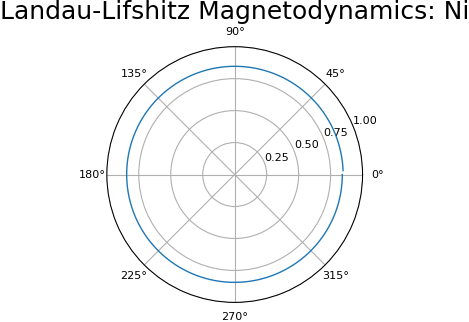

In [47]:
def rk4(x, t, tau, derivsRK, gamma, M_mag, H, theta, alpha):     #Garcia's rk4 function
    """
    Runge-Kutta integrator (4th order)
    Input arguments
    :param x: current value of dependent variable
    :param t: independent variable (usually time)
    :param tau: step size (usually time step)
    :param derivsRK: right hand side of the ODE; derivsRK is the name of the function which returns dx/dt
    Calling format derivsRK (x, t, param).
    :param param: estra parameters passed to derivsRK  GM in this case
    :return:
    xout: new value of x after a step of size tau
    """

    half_tau = 0.5*tau
    F1 = derivsRK(x, t, gamma, M_mag, H, theta, alpha)
    t_half = t + half_tau
    xtemp = x + half_tau*F1
    F2 = derivsRK(xtemp, t_half, gamma, M_mag, H, theta, alpha)
    xtemp = x + half_tau*F2
    F3 = derivsRK(xtemp, t_half, gamma, M_mag, H, theta, alpha)
    t_full = t + tau
    xtemp = x + tau*F3
    F4 = derivsRK(xtemp, t_full, gamma, M_mag, H, theta, alpha)
    xout = x + tau/6.0 * (F1 + F4 + 2.0*(F2+F3))

    return xout # magnetization vector

def LL_rk(s, t, gamma, M_mag, H, theta, alpha):       #Landau-Lifshitz Equation         
    """ 
    Returns the right-hand side of the Kepler ODE; used by Runge-Kutta routines
    :param s: State vector [r(0), r(1), r(2), v(0), v(1), v(2)]
    :param t: Time 
    :return: deriv: Derivatives [dr(0)/dt), dr(1)/dt, dr(2)/dt, dv(0)/dt, dv(1)/dt, dr(2)/dt]
    """

    # Compute dM/dt
    r = s[:3]  # Unravel the vector s into position and velocity
    v = s[3:]
    #accel = -GM * r / np.linalg.norm(r)**3  #Keplerian Gravitational acceleration
    torque = -gamma*np.cross(r, H)
    damping = -alpha/M_mag * np.cross(r, torque)
    
    # Return derivatives
    deriv = torque + damping   # dm/dt vector
    
    return deriv

def dinput(input_text) :           #text input functions
    return int(input(input_text))

def finput(input_text) :
    return float(input(input_text))


#Declare constants & Input physical parameters
M_mag =   1    # [Tesla]
theta_0 = 1    # [radians]
H_mag =   1    # [Tesla]  
time = 0.0

#Test Inputs
gamma_0 = -1/2
alpha_0 = 0
dt_0 = .005
nStep_0 = 2500

#Inputs for Iron
gamma_Fe = -8.681*10**6
alpha_Fe = 700*(M_mag)/8.681
dt_Fe = .00000001
nStep_Fe = 1200

#Inputs for Nickel
gamma_Ni = -1.83*7.622593285e6/.01952 
alpha_Ni = 0.0405
dt_Ni = .0000000001
nStep_Ni = 1200

#Inputs used in calculations
gamma = gamma_0    # gyromagnetic ratio [radians/sec/Tesla]      
alpha = alpha_0    # damping factor [dimensionless]     
dt = dt_0          #seconds
nStep = nStep_0


M_vector = np.array([M_mag*np.sin(theta_0), 0.0, M_mag*np.cos(theta_0)]) #initial magnetization vector
dM = np.array([0.0, 0.0, 0.0])      #needs to be edited
state = np.array([M_vector[0], M_vector[1], M_vector[2], dM[0], dM[1], dM[2]])
H_eff = np.array([0.0, 0.0, H_mag])
theta = theta_0

freq_res = abs(gamma*H_mag)/(2*np.pi)     #calculate Resonant frequency [Hz]


# create data arrays
rplot = np.zeros(nStep)
phiplot = np.zeros(nStep)
tplot = np.zeros(nStep)
xplot = np.zeros(nStep)
yplot = np.zeros(nStep)
zplot = np.zeros(nStep)
magplot = np.zeros(nStep)

method = 0     # rk4
#method = 1     # Euler-Cromer

#Recursively calculate M(t) using rk4
for iStep in range(nStep):

    # Record position and energy for plotting
    rplot[iStep] = np.sqrt(state[0]**2 + state[1]**2)  # Record radial position and angle for polar plot
    phiplot[iStep] = np.arctan2(state[1], state[0])
    tplot[iStep] = time
    theta = np.arctan2(state[2], np.sqrt(state[0]**2 + state[1]**2))
    xplot[iStep] = state[0]
    yplot[iStep] = state[1]
    zplot[iStep] = state[2]
    magplot[iStep] = np.sqrt(state[0]**2 + state[1]**2 + state[2]**2)
    
    if method == 0:
    # Calculate new position and velocity using the Runge-Kutta method
        state[:3] = rk4(state[:3], time, dt, LL_rk, gamma, M_mag, H_eff, theta, alpha) # m vector
        state[3:] = LL_rk(state, time, gamma, M_mag, H_eff, theta, alpha)              # dm/dt vector
        time += dt
    else:
    # Calculate new position and velocity using the Euler-Cromer method
        state[3:] = LL_rk(state, time, gamma, M_mag, H_eff, theta, alpha)              # dm/dt vector
        state[:3] = state[:3] + state[3:]*dt                                           # m vector
        #state[3:] = LL_rk(state, time, gamma, M_mag, H_eff, theta, alpha)              # dm/dt vector
        time += dt    

# Polar Graph (xy-projection)
D = M_mag #Sizing parameter
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(phiplot, rplot)
ax.set_rmax(D)
ax.set_rticks([D/4, D/2, 3*D/4, D])
ax.set_title('Landau-Lifshitz Magnetodynamics: Ni')
ax.tick_params(labelsize=8)


print('The resonant frequency of this system is:', freq_res, 'Hz.')
print(magplot)
print('α =', alpha)
print('γ =', gamma, '[rad/s/T]')
print('|M| =', M_mag, '[T]')


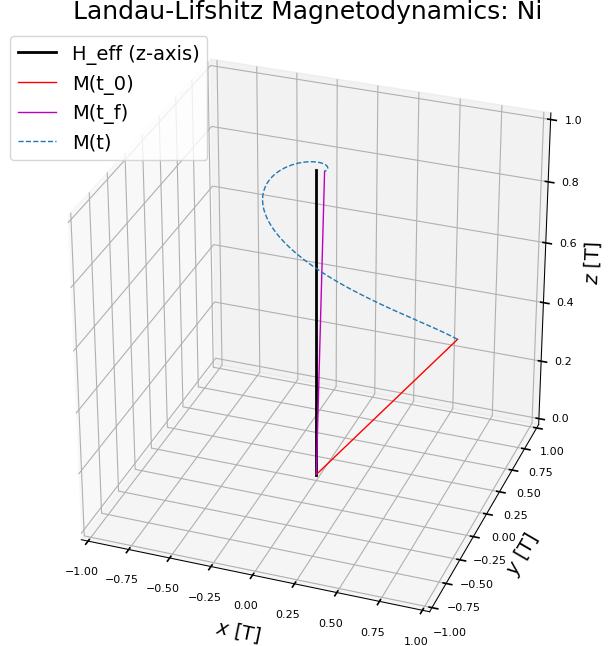

In [26]:
from mpl_toolkits import mplot3d

# Initial Mag Vector Position
initx = np.array([0, xplot[0]])
inity = np.array([0, yplot[0]])
initz = np.array([0, zplot[0]])

# Final Mag Vector Position
finx = np.array([0, xplot[-1]])
finy = np.array([0, yplot[-1]])
finz = np.array([0, zplot[-1]])

# H_eff / z-axis
axx = np.array([0, 0])
axy = np.array([0, 0])
axz = np.array([0, M_mag])

#3D plot of M(t)
fig1 = plt.figure(figsize=(8,8))
ax1 = plt.axes(projection='3d')
ax1.set_box_aspect((1,1,1))
ax1.plot3D(axx, axy, axz, c='k', lw=2, label='H_eff (z-axis)')
ax1.plot3D(initx, inity, initz, c='r', label='M(t_0)')
ax1.plot3D(finx, finy, finz, c='m', label='M(t_f)')
ax1.plot3D(xplot, yplot, zplot, ls='--', label='M(t)')
ax1.view_init(30,-70) # tilt, rotate angles
ax1.set_xlabel('$x$ [T]')
ax1.set_ylabel('$y$ [T]')
ax1.set_zlabel('$z$ [T]')
ax1.set_xlim(-M_mag,M_mag)
ax1.set_ylim(-M_mag,M_mag)
ax1.set_zlim(0,M_mag)
ax1.set_title('Landau-Lifshitz Magnetodynamics: Ni')
ax1.tick_params('both', length=10, width=1.2, which='major',labelsize=8)
ax1.legend(loc='upper left')

plt.show()

Fit Amplitude = 0.9050000000000001
Fit Decay Rate = 0.21800000000000005
Least Squares Fit = 0.49196381668868044 [T^2]


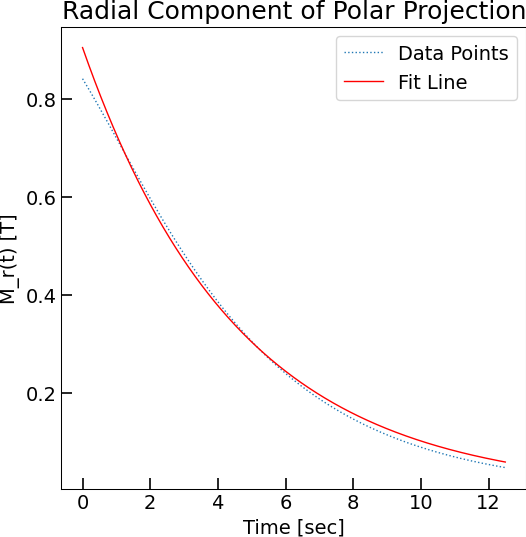

In [41]:
amp = 0.8
w = 0.1500
rows = 500
cols = rows
lsq = 100.0 #[[0 for j in range(cols)] for i in range(rows)] #2d array for least squares fit

for g in range (rows):     #loop performs 3e7 calculations
    for h in range (cols):
        expfit = amp*np.exp(-w*tplot)
        err = sum((expfit - rplot)**2)
        if err < lsq:
            lsq = err
            A = amp
            omega = w 
        w += h * 0.0005
    w = 0.1500
    amp += g * 0.005
        
#print(min(min(lsq)))
#for x in range (rows):
#    for y in range (cols):
#        if lsq[x][y] == min(min(lsq)):
#            A = 0.0008250 + x*0.001
#            omega = w + y*0.0001
#            print('Fit Amplitude =', A)
#            print('Fit Decay Rate =', omega)

fit = A*np.exp(-omega*tplot)

print('Fit Amplitude =', A)
print('Fit Decay Rate =', omega)
print('Least Squares Fit =',lsq, '[T^2]')

fig2 = plt.figure(figsize=(6,6))
plt.plot(tplot, rplot, ls='dotted', label='Data Points')
plt.plot(tplot, fit, c='r', label='Fit Line')
#plt.plot(tplot, 1/((1/max(rplot))+tplot), c='g')
plt.title('Radial Component of Polar Projection')
plt.xlabel('Time [sec]')
plt.ylabel('M_r(t) [T]')
plt.legend()

1.9238945577107864


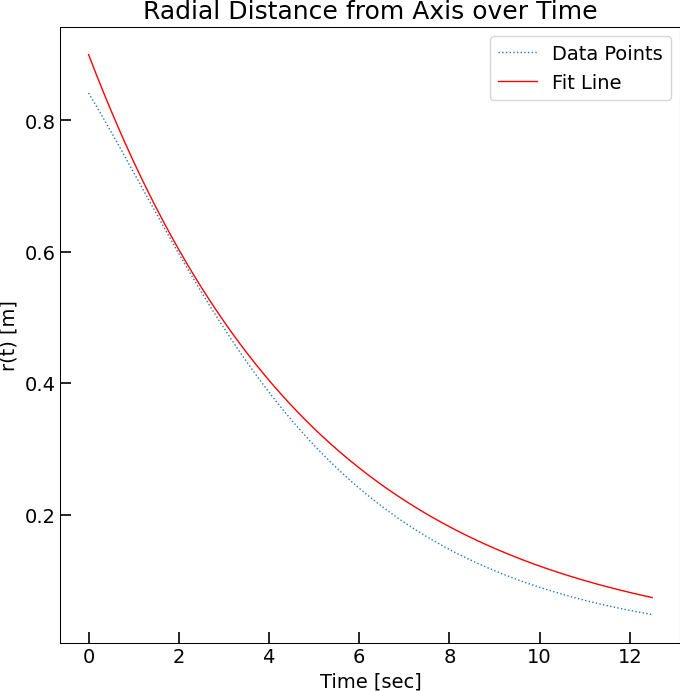

In [39]:
A = 0.9
omega = 0.20
fit = A*np.exp(-omega*tplot)

diff2 = (fit-rplot)**2
lsqf = sum(diff2)

print(lsqf)

fig2 = plt.figure(figsize=(8,8))
plt.plot(tplot, rplot, ls='dotted', label='Data Points')
plt.plot(tplot, fit, c='r', label='Fit Line')
plt.title('Radial Distance from Axis over Time')
plt.xlabel('Time [sec]')
plt.ylabel('r(t) [m]')
plt.legend()